In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
import joblib

In [2]:
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"
]
df = pd.read_csv(url, names=column_names, na_values="?")

In [ ]:
# Display basic info
print(df.head())
print(df.isnull().sum())

    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64


In [ ]:
df["target"] = df["target"].apply(lambda x: 1 if x > 0 else 0)

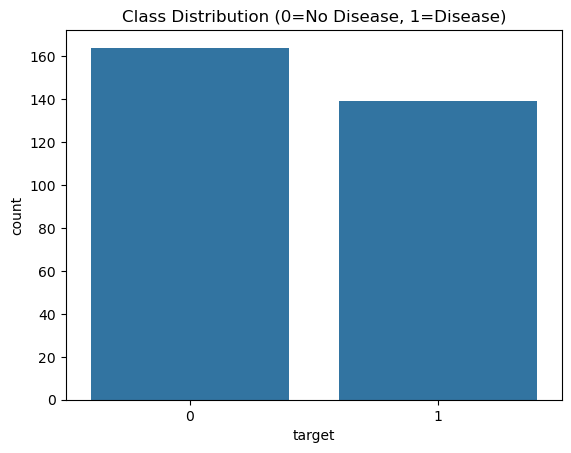

In [5]:
# Visualize class distribution
sns.countplot(x="target", data=df)
plt.title("Class Distribution (0=No Disease, 1=Disease)")
plt.show()

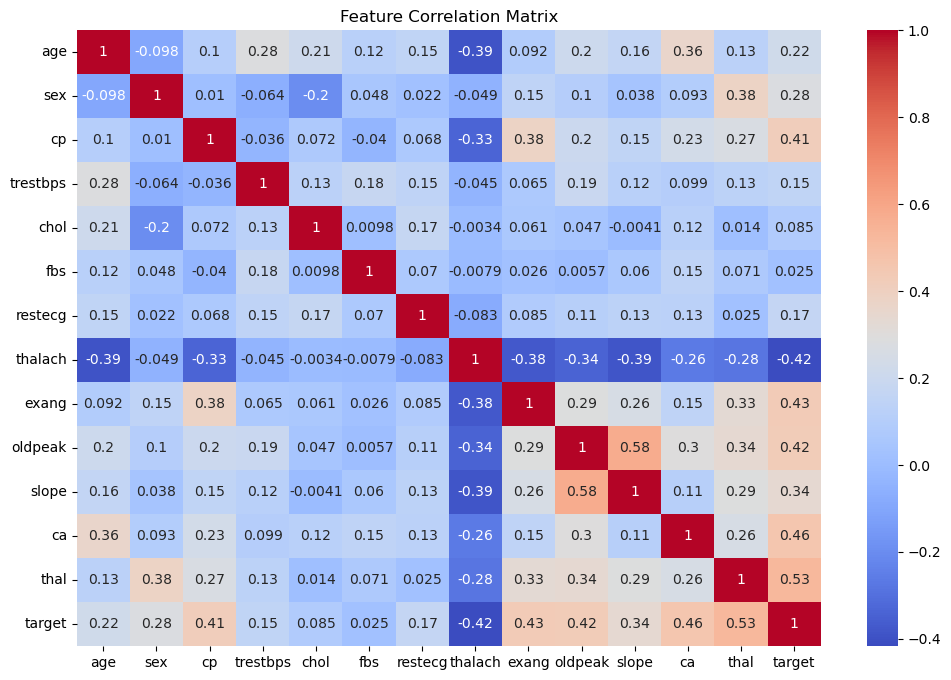

In [6]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [7]:
# Separate features and target
X = df.drop("target", axis=1)
y = df["target"]

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
# Preprocessing pipeline
numeric_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]
numeric_transformer = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())
])

categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [11]:
# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [12]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Define models and grids
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {"C": [0.1, 1, 10]}
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {"n_estimators": [100, 200], "max_depth": [3, 5, None]}
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric="logloss", random_state=42),
        "params": {"learning_rate": [0.01, 0.1], "n_estimators": [100, 200]}
    }
}

In [15]:
# Train and tune models
results = {}
for name, config in models.items():
    grid = GridSearchCV(config["model"], config["params"], cv=3, scoring="roc_auc")
    grid.fit(X_train_res, y_train_res)
    
    # Evaluate best model
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]
    
    results[name] = {
        "Best Params": grid.best_params_,
        "Accuracy": best_model.score(X_test, y_test),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    }

In [16]:
# Display results
pd.DataFrame(results).T

,Best Params,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Logistic Regression,{'C': 1},0.868852,0.8125,0.928571,0.866667,0.964286
Random Forest,"{'max_depth': None, 'n_estimators': 200}",0.901639,0.84375,0.964286,0.9,0.937771
XGBoost,"{'learning_rate': 0.1, 'n_estimators': 200}",0.868852,0.8125,0.928571,0.866667,0.9329


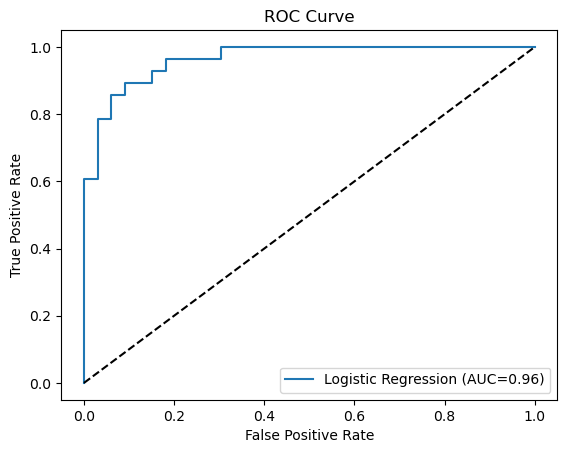

In [17]:
# Plot ROC curve for best model (e.g., XGBoost)
best_model = list(results.keys())[np.argmax([v["ROC-AUC"] for v in results.values()])]
model = models[best_model]["model"].set_params(**results[best_model]["Best Params"])
model.fit(X_train_res, y_train_res)

fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f"{best_model} (AUC={results[best_model]['ROC-AUC']:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [18]:
# Feature importance (for tree-based models)
if "feature_importances_" in dir(model):
    feature_names = numeric_features + list(preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(categorical_features))
    importances = pd.Series(model.feature_importances_, index=feature_names)
    importances.sort_values(ascending=False).plot.bar(title="Feature Importance")
    plt.show()

In [19]:
# Save the best model
joblib.dump(model, "disease_model.pkl")

['disease_model.pkl']

In [20]:
# Example prediction function
def predict_disease(input_data):
    input_df = pd.DataFrame([input_data])
    input_processed = preprocessor.transform(input_df)
    prediction = model.predict_proba(input_processed)[:, 1][0]
    return f"Disease Probability: {prediction:.2%}"

In [21]:
# Test with sample data
sample_input = {
    "age": 52, "sex": 1, "cp": 0, "trestbps": 125, "chol": 212,
    "fbs": 0, "restecg": 1, "thalach": 168, "exang": 0, "oldpeak": 1.0,
    "slope": 2, "ca": 2, "thal": 3
}
print(predict_disease(sample_input))

Disease Probability: 68.67%
